# Split into 500 and 330 group, find features on 500 and test on 330

models: Linear, LASSO, MLP, LatSim + Correlation Top 10 both 5 positive + 5 negative
task: rest, nback, emoid
preproc: FC, PC

In [26]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['sex'].keys()))
print(len(subs))

830


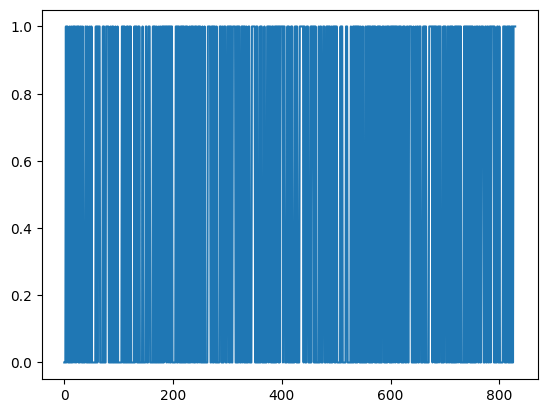

In [27]:
import matplotlib.pyplot as plt

plt.plot([demo['sex'][sub] == 'M' for sub in subs])
plt.show()

In [70]:
import numpy as np
from sklearn.decomposition import PCA

task = 'rest'
pre = 'fc'

# Load FC 

fcs = []
race = []

for sub in subs:
    fname = f'{basedir}/{pre}/{sub}_task-{task}_{pre}.npy'
#     if demo['race'][sub] == 'EA':
#         race.append(0)
#     elif demo['race'][sub] == 'AA':
#         race.append(1)
#     else:
#         continue
    fc = np.load(fname)
    fcs.append(fc)
    race.append(int(demo['sex'][sub] == 'M'))
    
fcs = np.stack(fcs)
    
race = np.array(race)
print(fcs.shape)
print(race.shape)
print(np.mean(race))
print(race[0:3])

(830, 34716)
(830,)
0.4602409638554217
[0 0 0]


In [71]:
# Correlation

ntrain = 600

x = fcs[:ntrain]
mux = np.mean(x, axis=0, keepdims=True)
x = x - mux
y = race[:ntrain]
muy = np.mean(y)
y = y - muy
xx = np.einsum('ab,ab->b',x,x)
yy = np.einsum('a,a->',y,y)
xy = np.einsum('ab,a->b',x,y)
rho = xy / (xx*yy)**0.5
rho[np.isnan(rho)] = 0

idcs = np.argsort(rho)
bot_idcs = idcs[0:5]
top_idcs = idcs[-5:]
print('Done')
print(rho[bot_idcs])
print(rho[top_idcs])

Done
[-0.13531207 -0.13197693 -0.12990284 -0.12794093 -0.12446845]
[0.22645848 0.22943684 0.23137819 0.2383734  0.24463779]


In [73]:
# Test correlation

from sklearn.linear_model import LogisticRegression

sav_idcs = np.concatenate([bot_idcs, top_idcs])
print(sav_idcs)

ntrain = 600

xtr = fcs[:ntrain]#[:,sav_idcs]
xt = fcs[ntrain:]#[:,sav_idcs]

ytr = race[:ntrain]
yt = race[ntrain:]

# muy = np.mean(ytr)
# ytr = ytr - muy
# yt = yt - muy

reg = LogisticRegression(fit_intercept=True, max_iter=1000).fit(xtr, ytr)
yhat = reg.predict(xt)

print(np.mean((yhat == yt).astype('int')))
print(np.mean(yt))

[ 2505  2438  2154  2184   424 12393 20612 33090 12285 31870]
0.6695652173913044
0.508695652173913


In [75]:
# Linear

from sklearn.linear_model import Lasso

ntrain = 600
nn = 500
rs = []
coef = []

for i in range(20):
    idcs = np.random.permutation(ntrain)
    x = fcs[:ntrain]
    x = x[idcs]
    xtr = x[:nn]
    xt = x[nn:]

    y = race[:ntrain]
    y = y[idcs]
    ytr = y[:nn]
    yt = y[nn:]
    
#     muy = np.mean(ytr)
#     ytr = ytr - muy
#     yt = yt - muy

    clf = LogisticRegression(max_iter=1000).fit(xtr, ytr)
    yhat = clf.predict(xt)
    acc = np.mean((yhat == yt).astype("int"))
    acc = float(acc)
    print(acc)
    rs.append(acc)
    coef.append(clf.coef_*np.mean(xtr, axis=0))
    acc = np.mean(yt)
    acc = float(acc)
    print(acc)
    
print('---')
print(np.mean(rs))
print(np.std(rs))
yt = race[:ntrain]
print(np.mean(yt))
# idcs = np.argsort(np.abs(reg.coef_))[-10:]
# print(idcs)
# reg.coef_[idcs]

0.68
0.51
0.67
0.4
0.67
0.45
0.76
0.41
0.7
0.46
0.69
0.46
0.66
0.45
0.68
0.42
0.78
0.41
0.71
0.45
0.76
0.43
0.66
0.45
0.75
0.44
0.72
0.49
0.71
0.52
0.7
0.37
0.73
0.42
0.6
0.51
0.6
0.44
0.68
0.44
---
0.6954999999999999
0.04663421490708298
0.44166666666666665


In [76]:
cc = np.stack(coef)
cc = np.mean(cc, axis=0).reshape(-1)
idcs = np.argsort(cc)
# idcs = np.argsort(np.abs(cc))[-10:]
idcs = np.concatenate([idcs[:5], idcs[-5:]])
print(idcs)
print(cc[idcs])

[21945  6769  8145  9523 29670 33345 21188 32916  2182 30062]
[-0.03814905 -0.03453457 -0.03450591 -0.03410931 -0.03379846  0.03280293
  0.0343387   0.03852862  0.0406674   0.0433597 ]


In [77]:
# Test linear

ntrain = 600

xtr = fcs[:ntrain][:,idcs]
xt = fcs[ntrain:][:,idcs]

ytr = race[:ntrain]
yt = race[ntrain:]

# muy = np.mean(ytr)
# ytr = ytr - muy
# yt = yt - muy

clf = LogisticRegression(max_iter=1000).fit(xtr, ytr)
yhat = clf.predict(xt)
acc = np.mean((yhat == yt).astype("int"))
acc = float(acc)
print(acc)
acc = np.mean(yt)
print(acc)

0.5608695652173913
0.508695652173913


In [351]:
reg.coef_

array([-3657.796 , -1838.8344, -2061.6082, -3549.03  , -4862.9214,
        2681.03  ,   921.5452,  4463.8643,  1111.3763,   645.9765],
      dtype=float32)

In [74]:
from sklearn.linear_model import LogisticRegression

# Greedy selection

ntrain = 600

x = fcs[:ntrain]
mux = np.mean(x, axis=0, keepdims=True)
x = x - mux

r = race[:ntrain]
sel_idcs = []

for i in range(10):
    mur = np.mean(r)
    r = r - mur
    xx = np.einsum('ab,ab->b',x,x)
    rr = np.einsum('a,a->',r,r)
    xr = np.einsum('ab,a->b',x,r)
    rho = xr / (xx*rr)**0.5
    rho[np.isnan(rho)] = 0

    idcs = np.argsort(np.abs(rho))[::-1]
    for j in range(10):
        if idcs[j] not in sel_idcs:
            sel_idcs.append(idcs[j])
            break
            
    xtr = fcs[:ntrain][:,sel_idcs]
    xt = fcs[ntrain:][:,sel_idcs]
    
#     mux = np.mean(xtr, axis=0, keepdims=True)
#     xtr = xtr - mux
#     xt = xt - mux
    
    ytr = race[:ntrain]
    yt = race[ntrain:]
    
#     muy = np.mean(ytr)
#     ytr = ytr - muy
#     yt = yt - muy
    
    print(sel_idcs)
    
    reg = LogisticRegression(fit_intercept=True,max_iter=1000).fit(xtr, ytr)
    yhat = reg.predict(xt)
    acc = np.mean((yhat == yt).astype("int"))
    acc = float(acc)
    print(acc)
    
    yhat = reg.predict(xtr)
    acc = np.mean((yhat == ytr).astype("int"))
    acc = float(acc)
    print(acc)
    r = ytr-yhat
    

[31870]
0.5826086956521739
0.5916666666666667
[31870, 32245]
0.5826086956521739
0.59
[31870, 32245, 32244]
0.5826086956521739
0.5916666666666667
[31870, 32245, 32244, 19415]
0.6
0.5933333333333334
[31870, 32245, 32244, 19415, 18887]
0.6
0.5933333333333334
[31870, 32245, 32244, 19415, 18887, 29590]
0.5869565217391305
0.605
[31870, 32245, 32244, 19415, 18887, 29590, 19934]
0.5695652173913044
0.6083333333333333
[31870, 32245, 32244, 19415, 18887, 29590, 19934, 19240]
0.5652173913043478
0.605
[31870, 32245, 32244, 19415, 18887, 29590, 19934, 19240, 20612]
0.5608695652173913
0.6183333333333333
[31870, 32245, 32244, 19415, 18887, 29590, 19934, 19240, 20612, 21016]
0.6
0.6183333333333333


In [399]:
reg.coef_

array([  7463.6084,  -4352.4053,  -3071.0046,   1953.1709,   5202.3657,
         2084.6672, -10938.381 ,    653.9859,    768.9256,  -3837.0686],
      dtype=float32)

In [478]:
np.mean((ytr-np.mean(ytr))**2)**0.5

16.010211241579544